In [1]:
import zipfile
import os

In [2]:
!unzip /content/drive/MyDrive/endo_dataset/endo_dataset.zip -d /content/endo_dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/endo_dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9042.jpg  
  inflating: /content/endo_dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9043.jpg  
  inflating: /content/endo_dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9044.jpg  
  inflating: /content/endo_dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9045.jpg  
  inflating: /content/endo_dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9046.jpg  
  inflating: /content/endo_dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9047.jpg  
  inflating: /content/endo_dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9049.jpg  
  inflating: /content/endo_dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9052.jpg  
  inflating: /content/endo_dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_9054.jpg  
  inflating: /content/endo_dataset/Dataset/validation/Normal/KVASIR/dc221ccc65d34010_

In [3]:
dataset_zip = "/content/drive/MyDrive/endo_dataset.zip"
dataset_dir = "/content/endo_dataset/Dataset"
training_dir = os.path.join(dataset_dir, "training")
validation_dir = os.path.join(dataset_dir, "validation")
print(f"Training directory: {training_dir}")
print(f"Validation directory: {validation_dir}")

Training directory: /content/endo_dataset/Dataset/training
Validation directory: /content/endo_dataset/Dataset/validation


In [4]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 1.9 MB/s eta 0:00:00


In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Attention, Activation
from keras.layers import Dropout, BatchNormalization, Multiply
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.utils import class_weight
from keras.applications import Xception
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
import tensorflow as tf
import xgboost as xgb
from sklearn.metrics import accuracy_score
import os

In [6]:
def load_and_preprocess_image(base_dir, path, target_size):
    img_path = os.path.join(base_dir, path.replace('\\', '/'))
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    preprocessed_img = preprocess_input(img_array)
    return preprocessed_img

def get_data_for_training(excel_path, base_dir, image_size=(32, 32)):
    df = pd.read_excel(excel_path)
    df = df.dropna(subset=['image_path'])
    class_names = df.columns[2:]
    X = np.array([load_and_preprocess_image(base_dir, path, image_size) for path in df['image_path'].values])
    y = df[class_names].values
    return X, y, df['image_path'].values

In [7]:
if __name__ == "__main__":
    train_excel_path = "/content/endo_dataset/Dataset/training/training_data.xlsx"
    val_excel_path = "/content/endo_dataset/Dataset/validation/validation_data.xlsx"
    base_dir = "/content/endo_dataset/Dataset"
    image_size = (32, 32)
    batch_size = 4096
    epochs = 10

In [8]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.5 MB/s eta 0:00:00


In [9]:
from sklearn.utils import class_weight
import numpy as np

# Load full training and validation data
X_train_full, y_train_full, _ = get_data_for_training(train_excel_path, base_dir, image_size=image_size)
print("Full train data loaded")
X_val_full, y_val_full, image_paths = get_data_for_training(val_excel_path, base_dir, image_size=image_size)
print("Full val data loaded")

# Loading of training data
train_sample_size = int(len(X_train_full))
val_sample_size = int(len(X_val_full))

# Calculate class weights based on the training data
class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
y_train_labels = np.argmax(y_train_full, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

Full train data loaded
Full val data loaded


In [14]:
from tensorflow.keras import regularizers

# Custom SVM Layer
class SVMLayer(tf.keras.layers.Layer):
    def __init__(self, num_classes, **kwargs):
        super(SVMLayer, self).__init__(**kwargs)
        self.num_classes = num_classes

    def build(self, input_shape):
        # Use a Dense layer to simulate the SVM
        # Changed 'weights' to 'svm_weights' to avoid conflict
        self.svm_weights = self.add_weight(
            name='svm_weights',
            shape=(input_shape[1], self.num_classes),  # input features to number of classes
            initializer='random_normal',
            trainable=True
        )
        # Changed 'bias' to 'svm_bias' to avoid potential conflicts
        self.svm_bias = self.add_weight(
            name='svm_bias',
            shape=(self.num_classes,),
            initializer='zeros',
            trainable=True
        )

    def call(self, inputs):
        # SVM decision function: w * x + b
        # Use svm_weights and svm_bias
        return tf.matmul(inputs, self.svm_weights) + self.svm_bias

In [15]:
def attention_block(x):
    # Ensure the attention block has the same number of filters as x
    attention = Conv2D(128, kernel_size=(1, 1), padding='same', activation='sigmoid')(x)
    return Multiply()([x, attention])

# Create the Attention-based CNN model
def create_attention_cnn(input_shape):
    inputs = Input(shape=input_shape)

    # First Convolution Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Second Convolution Block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Apply attention block after second convolution block
    x = attention_block(x)

    # Third Convolution Block
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Fourth Convolution Block
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = SVMLayer(num_classes=10)(x)

    # Output Layer
    outputs = Dense(10, activation='softmax')(x)  # Assuming 10 classes for the classification task

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [16]:
# Model Compilation
input_shape = (32, 32, 3)  # Assuming input images of size 224x224 with 3 channels
attention_cnn_model = create_attention_cnn(input_shape)

# Compile the model
attention_cnn_model.compile(optimizer=AdamW(learning_rate=0.0001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

In [17]:
history = attention_cnn_model.fit(
    X_train_full, y_train_full,
    epochs=20,
    validation_data=(X_val_full, y_val_full),
    class_weight=class_weights_dict  # Apply computed class weights
)

Epoch 1/20
1176/1176 [==============================] - 60s 49ms/step - loss: 1.5818 - accuracy: 0.4771 - val_loss: 1.1748 - val_accuracy: 0.6092
Epoch 2/20
1176/1176 [==============================] - 56s 48ms/step - loss: 1.1734 - accuracy: 0.5899 - val_loss: 1.2132 - val_accuracy: 0.5944
Epoch 3/20
1176/1176 [==============================] - 56s 48ms/step - loss: 1.0358 - accuracy: 0.6403 - val_loss: 1.0056 - val_accuracy: 0.6610
Epoch 4/20
1176/1176 [==============================] - 56s 48ms/step - loss: 0.9144 - accuracy: 0.6867 - val_loss: 0.9817 - val_accuracy: 0.6819
Epoch 5/20
1176/1176 [==============================] - 56s 48ms/step - loss: 0.8293 - accuracy: 0.7036 - val_loss: 0.9173 - val_accuracy: 0.7135
Epoch 6/20
1176/1176 [==============================] - 56s 48ms/step - loss: 0.7406 - accuracy: 0.7346 - val_loss: 0.8319 - val_accuracy: 0.7376
Epoch 7/20
1176/1176 [==============================] - 57s 48ms/step - loss: 0.6485 - accuracy: 0.7568 - val_loss: 0.6292 -

In [18]:
feature_extractor = Model(inputs=attention_cnn_model.input, outputs=attention_cnn_model.layers[-3].output)

# Extract features using the feature extractor on sampled data
train_features = feature_extractor.predict(X_train_full)  # Extracted features for training data
val_features = feature_extractor.predict(X_val_full)

505/505 [==============================] - 6s 12ms/step


In [19]:
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)

# Fit the model using extracted features and corresponding labels
xgb_model.fit(train_features, np.argmax(y_train_full, axis=1))

# Predict on validation set features
val_preds = xgb_model.predict(val_features)

# Evaluate accuracy on validation set
accuracy = accuracy_score(np.argmax(y_val_full, axis=1), val_preds)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8527151004215224


Confusion Matrix:
[[4.96981891e-01 0.00000000e+00 9.05432596e-02 6.03621730e-03
  0.00000000e+00 2.01207243e-03 3.74245473e-01 3.01810865e-02
  0.00000000e+00 0.00000000e+00]
 [8.35654596e-03 6.51810585e-01 9.47075209e-02 8.35654596e-03
  0.00000000e+00 2.78551532e-03 2.06128134e-01 2.78551532e-02
  0.00000000e+00 0.00000000e+00]
 [2.51082251e-02 2.42424242e-02 4.06926407e-01 2.42424242e-02
  1.47186147e-02 5.19480519e-03 4.62337662e-01 3.29004329e-02
  4.32900433e-03 0.00000000e+00]
 [6.73400673e-03 1.01010101e-02 2.42424242e-01 1.71717172e-01
  6.73400673e-03 0.00000000e+00 5.01683502e-01 6.06060606e-02
  0.00000000e+00 0.00000000e+00]
 [8.82352941e-03 0.00000000e+00 5.00000000e-02 8.82352941e-03
  6.35294118e-01 0.00000000e+00 2.85294118e-01 1.17647059e-02
  0.00000000e+00 0.00000000e+00]
 [5.83090379e-03 0.00000000e+00 6.12244898e-02 2.91545190e-03
  2.91545190e-03 5.59766764e-01 3.44023324e-01 2.33236152e-02
  0.00000000e+00 0.00000000e+00]
 [2.27883129e-03 7.32481484e-04 2.059086

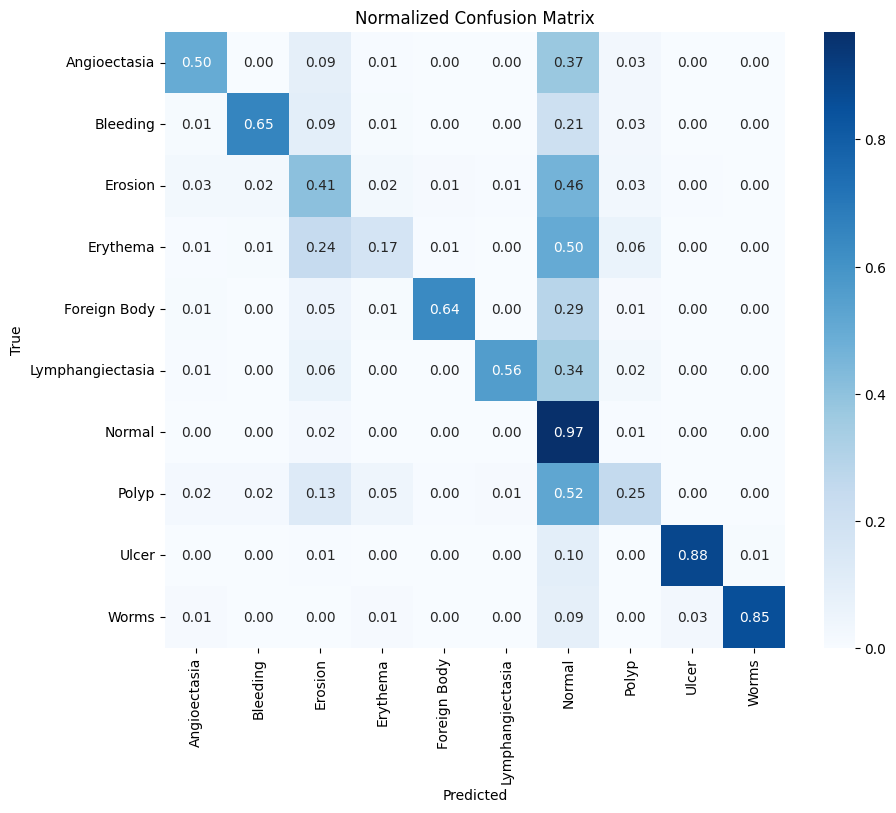

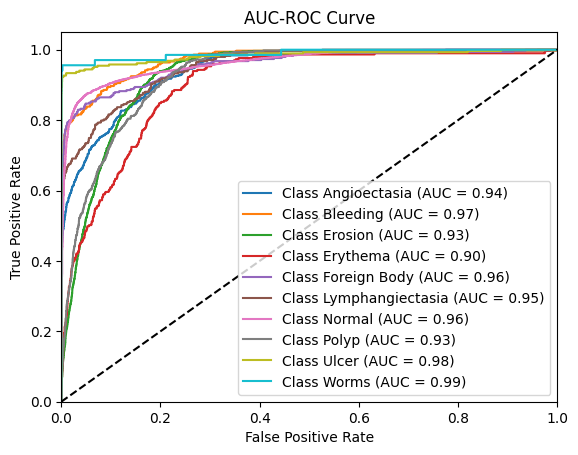

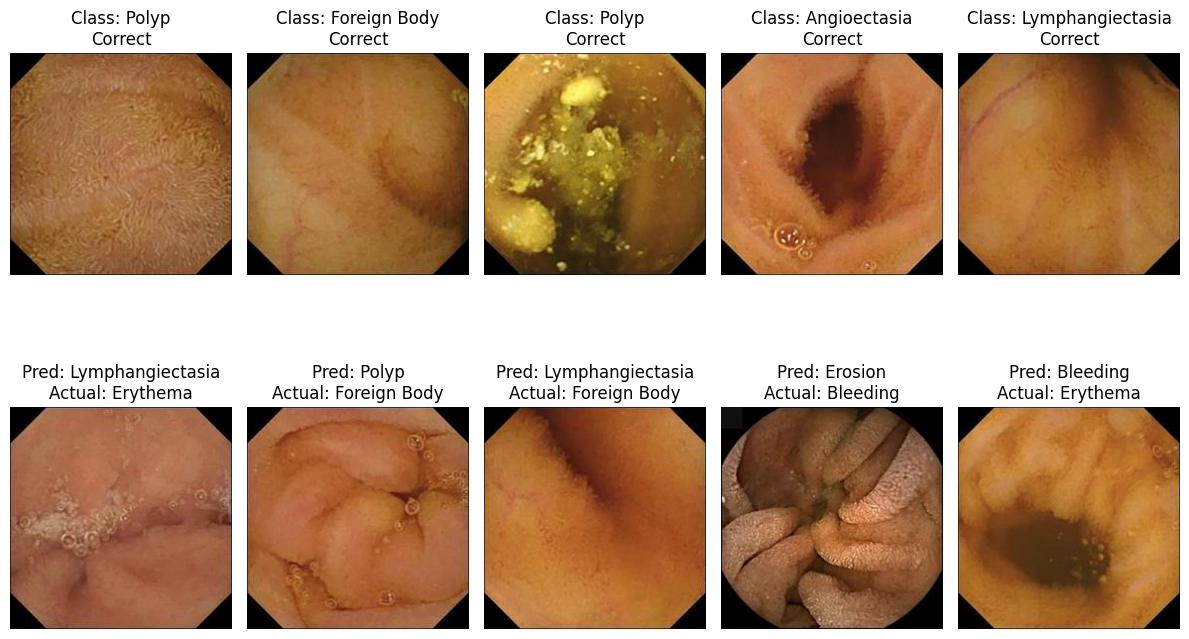

In [33]:
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras.preprocessing.image import load_img
from IPython.display import display

# Use the actual validation labels and predictions
y_val_classes = np.argmax(y_val_full, axis=1)  # True class labels
y_pred_classes = val_preds  # Predicted class labels

# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_val_classes, y_pred_classes, normalize='true')
print(cm)

# Print the classification report
print("Classification Report:")
print(classification_report(y_val_classes, y_pred_classes))

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Plot AUC-ROC curve for each class
lb = LabelBinarizer()
y_val_bin = lb.fit_transform(y_val_classes)
y_pred_proba = xgb_model.predict_proba(val_features)
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_val_bin[:, i], y_pred_proba[:, i])
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Assuming the base directory where images are stored
base_dir = '/content/endo_dataset/Dataset/validation'  # Adjust path accordingly

# Function to get image paths from subdirectories
def get_image_paths(base_dir):
    image_paths = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Add other image extensions if needed
                image_paths.append(os.path.join(root, file))
    return image_paths

# Retrieve all image paths from the directory
image_paths = get_image_paths(base_dir)

# Example class names (replace with actual class names if available)
class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']  # Adjust based on your dataset

# Simulate predictions and actual labels (replace with actual data)
y_val_classes = np.random.randint(0, len(class_names), size=len(image_paths))  # Example true labels
y_pred_classes = np.random.randint(0, len(class_names), size=len(image_paths))  # Example predicted labels

# Find indices of correctly and wrongly classified images
correct_indices = np.where(y_val_classes == y_pred_classes)[0]
wrong_indices = np.where(y_val_classes != y_pred_classes)[0]

# Randomly select 5 correct and 5 wrong samples
correct_sample_indices = np.random.choice(correct_indices, 5, replace=False)
wrong_sample_indices = np.random.choice(wrong_indices, 5, replace=False)

# Plot the correctly classified images and wrongly classified images
plt.figure(figsize=(12, 8))

# Display correct samples
for i, index in enumerate(correct_sample_indices):
    img_path = image_paths[index]  # Get the full image path
    try:
        img = load_img(img_path)  # Load the image
        plt.subplot(2, 5, i+1)  # Position the image in the plot
        plt.imshow(img)
        plt.title(f"Class: {class_names[y_val_classes[index]]}\nCorrect")
        plt.axis('off')
    except FileNotFoundError:
        print(f"Image not found: {img_path}")

# Display wrong samples
for i, index in enumerate(wrong_sample_indices):
    img_path = image_paths[index]  # Get the full image path
    try:
        img = load_img(img_path)  # Load the image
        plt.subplot(2, 5, 5+i+1)  # Position the image in the plot (below correct ones)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[y_pred_classes[index]]}\nActual: {class_names[y_val_classes[index]]}")
        plt.axis('off')
    except FileNotFoundError:
        print(f"Image not found: {img_path}")

plt.tight_layout()
plt.show()

In [34]:
# Calculate and print the mean AUC of all classes
mean_auc = np.mean(list(roc_auc.values()))
print(f'Mean AUC of all classes: {mean_auc:.2f}')

Mean AUC of all classes: 0.95


In [49]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def generate_grad_cam(model, image, class_index):
    # Get the last convolutional layer and the output layer
    last_conv_layer = model.get_layer("conv5_block3_out")  # Adjust layer name based on your model
    classifier_layer = model.get_layer("predictions")  # Adjust layer name based on your model

    # Create a model that outputs the last conv layer's output and the final predictions
    grad_model = tf.keras.models.Model(inputs=model.inputs,
                                       outputs=[last_conv_layer.output, classifier_layer.output])

    # Get the gradient of the class score with respect to the output of the convolutional layer
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        loss = predictions[:, class_index]

    # Compute gradients of the class with respect to the convolutional output
    grads = tape.gradient(loss, conv_output)

    # Pool the gradients across all the feature maps
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by the corresponding importance weight
    conv_output = conv_output[0]  # First image in the batch
    heatmap = np.mean(conv_output, axis=-1)  # Average over all channels
    heatmap = np.maximum(heatmap, 0)  # ReLU to avoid negative values
    heatmap /= np.max(heatmap)  # Normalize between 0 and 1

    # Resize the heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    return heatmap

# Generate Grad-CAM heatmap
image = load_img(image_paths[correct_sample_indices[0]])  # Load your image
image_array = np.array(image) / 255.0  # Preprocess the image

class_index = y_pred_classes[correct_sample_indices[0]]  # Use the predicted class
grad_cam_heatmap = generate_grad_cam(model, image_array, class_index)

# Display the Grad-CAM heatmap
plt.imshow(grad_cam_heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap on image
plt.axis('off')
plt.show()

NameError: name 'model' is not defined

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=25cb9a3c00ac99f8412012388dfd585ea8608f5b626141c0ff2dd773a5788252
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
import numpy as np
from skimage.color import rgb2lab
from skimage.segmentation import mark_boundaries
from lime import lime_image

In [ ]:
def explain_prediction(image, model, image_id):
    # Debug: Check the original shape and dtype
    print(f'Original image shape: {image.shape}, dtype: {image.dtype}')

    # Convert image to RGB if it has an alpha channel
    if image.shape[-1] == 4:  # Check for RGBA
        image = image[:, :, :3]  # Take only the RGB channels
        print('Converted from RGBA to RGB.')
    elif image.shape[-1] == 1:  # Check for grayscale
        image = np.repeat(image, 3, axis=-1)  # Convert to RGB by repeating channels
        print('Converted from grayscale to RGB.')

    # Ensure the image is in the correct format for LIME
    image = image.astype(np.float32)  # Ensure it's a float32 type

    # Debug: Check the new shape and dtype after conversion
    print(f'Processed image shape: {image.shape}, dtype: {image.dtype}')

    explainer = lime_image.LimeImageExplainer()

    # Ensure the image has three channels
    if image.shape[-1] != 3:
        raise ValueError(f'Image must have 3 channels, but has {image.shape[-1]}.')

    # Pass the image as is to explain_instance
    explanation = explainer.explain_instance(image, model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explainer.get_image_and_mask(explanation.top_labels[0], positive_only=False, hide_rest=False)

    img_boundry = mark_boundaries(temp / 255.0, mask)
    plt.imshow(img_boundry)
    plt.title(f'Explanation for Image ID: {image_id}')
    plt.axis('off')
    plt.show()

In [ ]:
# Example of explaining a random prediction
random_index = np.random.randint(0, len(X_val_full))

# Extract features for the random image
image_feature = feature_extractor.predict(X_val_full[random_index:random_index + 1])  # Use slicing to get a 1D array

# Explain the prediction using the extracted features
explain_prediction(image_feature[0], xgb_model, image_paths[random_index])

1/1 [==============================] - 0s 27ms/step
Original image shape: (256,), dtype: float32
Processed image shape: (256,), dtype: float32


ValueError: Image must have 3 channels, but has 256.

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# Assuming X_val_full and y_val_full are NumPy arrays already loaded
# Select a random image from the validation set
random_index = np.random.randint(0, len(X_val_full))
sample_image = X_val_full[random_index]  # Get the image
sample_label = y_val_full[random_index]  # Get the corresponding label

# Initialize the SHAP explainer with a background sample of images
background = X_val_full[:10]  # Use a few images as the background

# Load SHAP explainer for the attention-based CNN model, using the background images
explainer = shap.GradientExplainer(attention_cnn_model, background)

In [ ]:
def explain_shap_prediction(image, explainer):
    # Expand dimensions for the SHAP values
    image_expanded = np.expand_dims(image, axis=0)  # Shape (1, 32, 32, 3)

    # Generate SHAP values (assuming 'explainer' is already defined)
    shap_values = explainer.shap_values(image_expanded)  # This should return a list of arrays

    # Check the shape of the SHAP values
    for i, sv in enumerate(shap_values):
        print(f"SHAP values for class {i}: {sv.shape}")

    # The SHAP values should be a list of arrays with shape (1, 32, 32, 3)
    # Convert to a format suitable for plotting
    shap_values_combined = np.array(shap_values)  # Combine them into a numpy array (shape will be [10, 1, 32, 32, 3])

    # For plotting, you might need to swap axes depending on how the SHAP plotting function expects them
    # This assumes you want to visualize the first image's SHAP values for all classes
    shap_values_combined = shap_values_combined.reshape(10, 32, 32, 3)  # Shape (10, 32, 32, 3)

    # Plot SHAP explanation for each class
    plt.figure(figsize=(15, 15))
    for i in range(shap_values_combined.shape[0]):
        plt.subplot(4, 3, i + 1)
        shap.image_plot(shap_values_combined[i], image_expanded[0])
        plt.title(f"Class {i+1}")
    plt.show()


SHAP values for class 0: (32, 32, 3, 10)


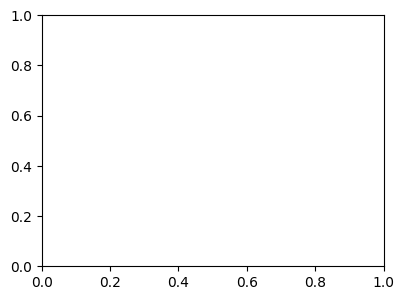

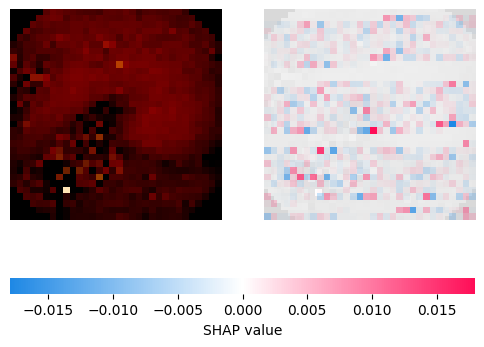

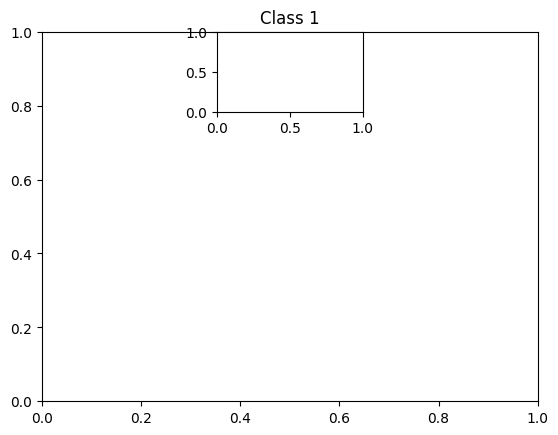

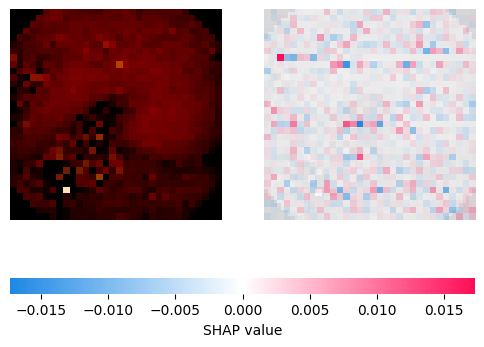

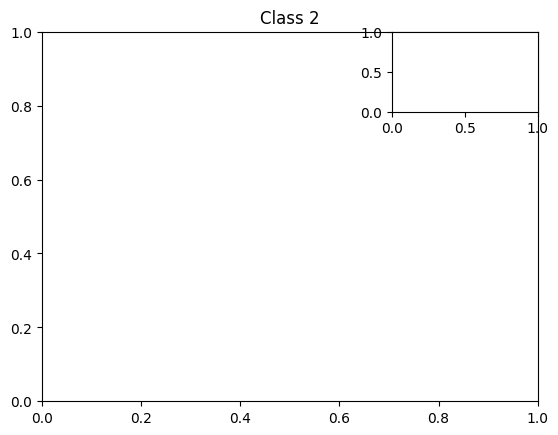

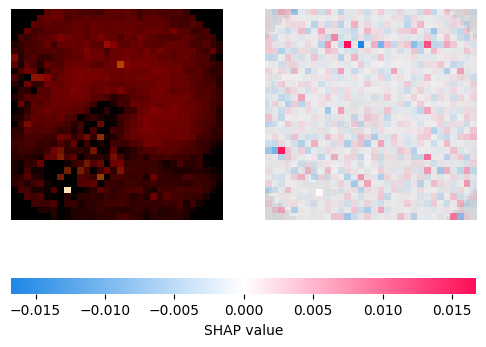

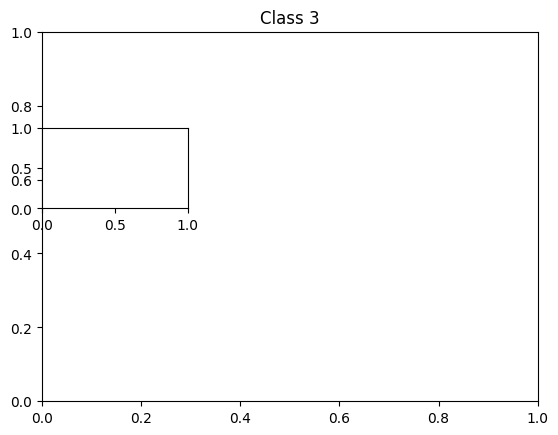

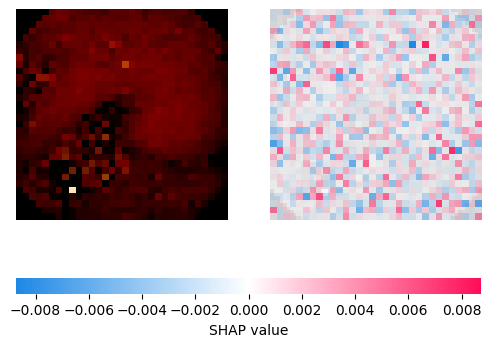

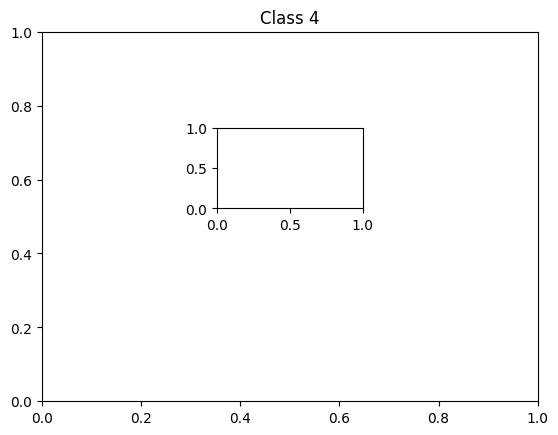

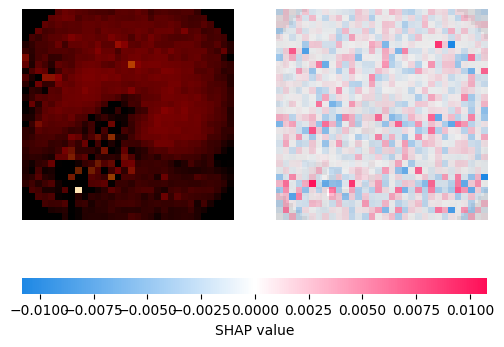

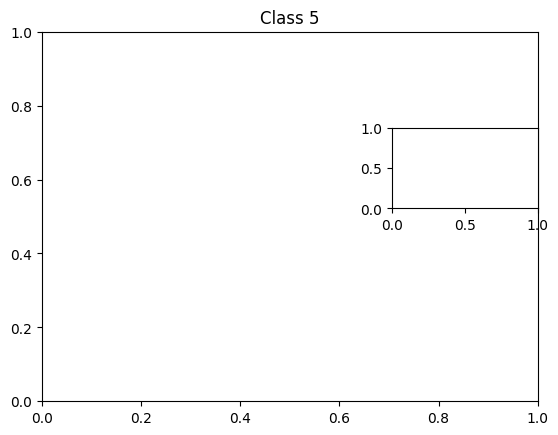

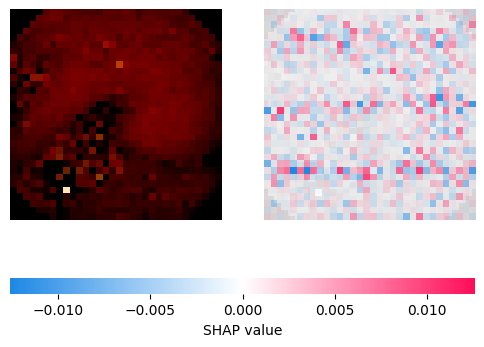

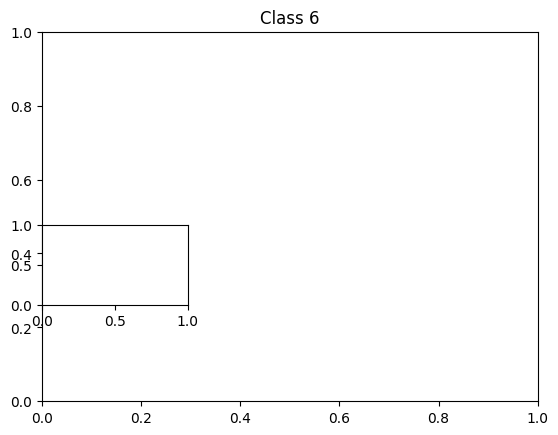

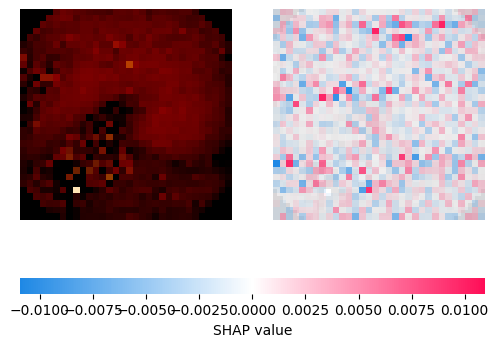

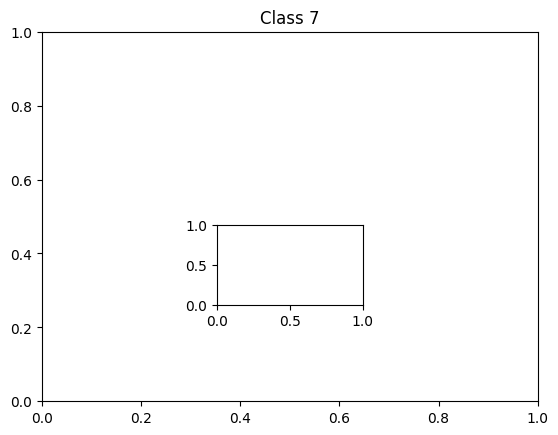

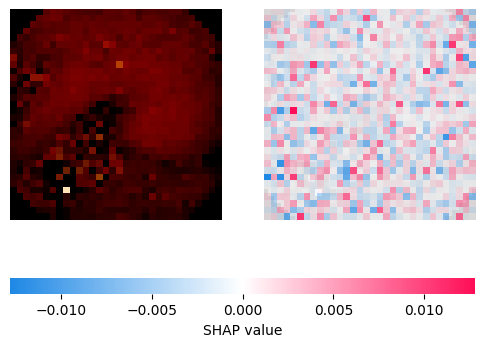

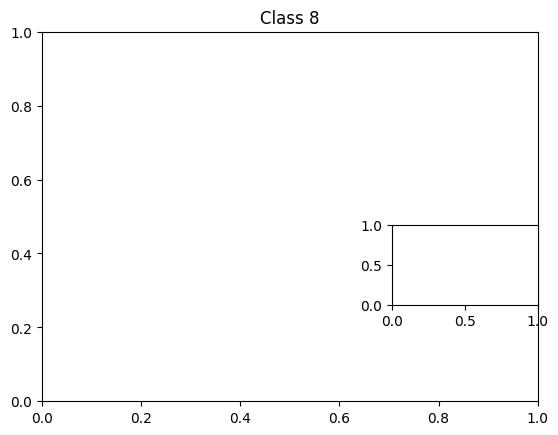

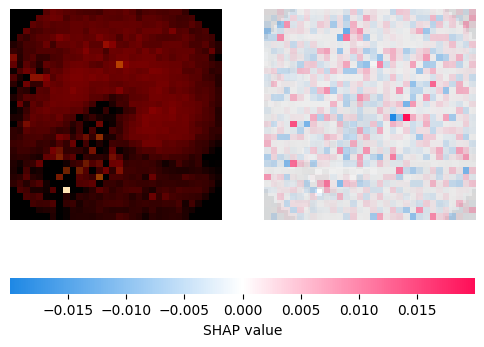

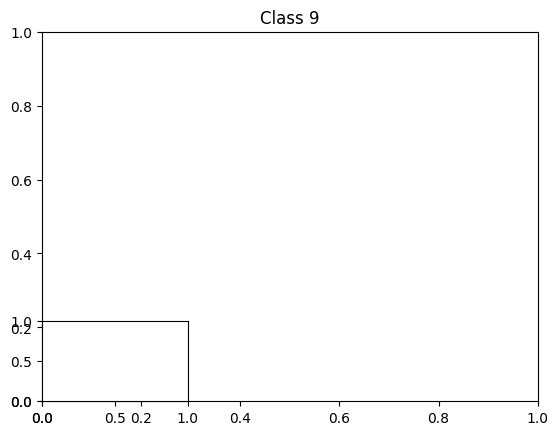

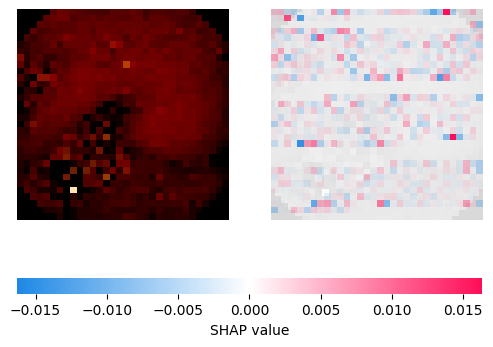

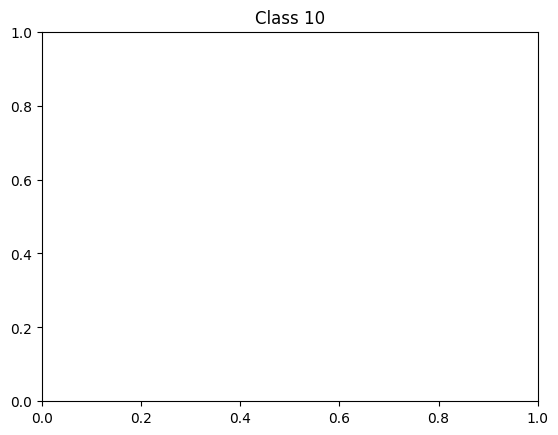

In [ ]:
# Explain the prediction for the selected sample image
explain_shap_prediction(sample_image, explainer)